In [11]:
import horton
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
def get_densities_at_nuclei(coords, zs):
    horton.log.set_level(1)
    mol = horton.IOData(title='test')
    mol.coordinates = np.array(coords)
    mol.numbers = np.array(zs)
    mol.pseudo_numbers = mol.numbers
    
    basisset = 'def2-TZVP'
    obasis = horton.get_gobasis(mol.coordinates, mol.numbers, basisset)
    
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)

    # Initial guess
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    grid = horton.BeckeMolGrid(mol.coordinates, mol.numbers, mol.pseudo_numbers)
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    terms = [
        horton.UTwoIndexTerm(kin, 'kin'),
        horton.UDirectTerm(er, 'hartree'),
        horton.UGridGroup(obasis, grid, [
            horton.ULibXCGGA('x_pbe'),
            horton.ULibXCGGA('c_pbe'),
        ]),
        horton.UTwoIndexTerm(na, 'ne'),
    ]
    ham = horton.UEffHam(terms, external)

    converged = False
    for solver in (horton.EDIIS2SCFSolver,horton.CDIISSCFSolver,horton.ODASCFSolver,  horton.EDIISSCFSolver, ):
        try:
            occ_model = horton.AufbauOccModel(sum(zs)/2, sum(zs)/2)
        
            occ_model.assign(orb_alpha, orb_beta)
            dm_alpha = orb_alpha.to_dm()
            dm_beta = orb_beta.to_dm()
            scf_solver = solver(1e-7, maxiter=100)
            scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
            converged = True
        except:
            continue
        if converged:
            break
    
    dens = obasis.compute_grid_density_dm(dm_alpha, mol.coordinates)
    dens += obasis.compute_grid_density_dm(dm_beta, mol.coordinates)
    return dens

In [43]:
rows = []
for molname, mol in zip('CO N2'.split(), ((6, 8), (7,7))):
    for distance in (0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 10.):
        try:
            dens = get_densities_at_nuclei([[0.,0.,0.], [0.,0.,distance*horton.angstrom]], mol)
            row = {'molname': molname, 'z1': mol[0], 'z2': mol[1], 'rho1': dens[0], 'rho2': dens[1], 'distance': distance}
            rows.append(row)
        except:
            raise
            continue
df = pd.DataFrame(rows)

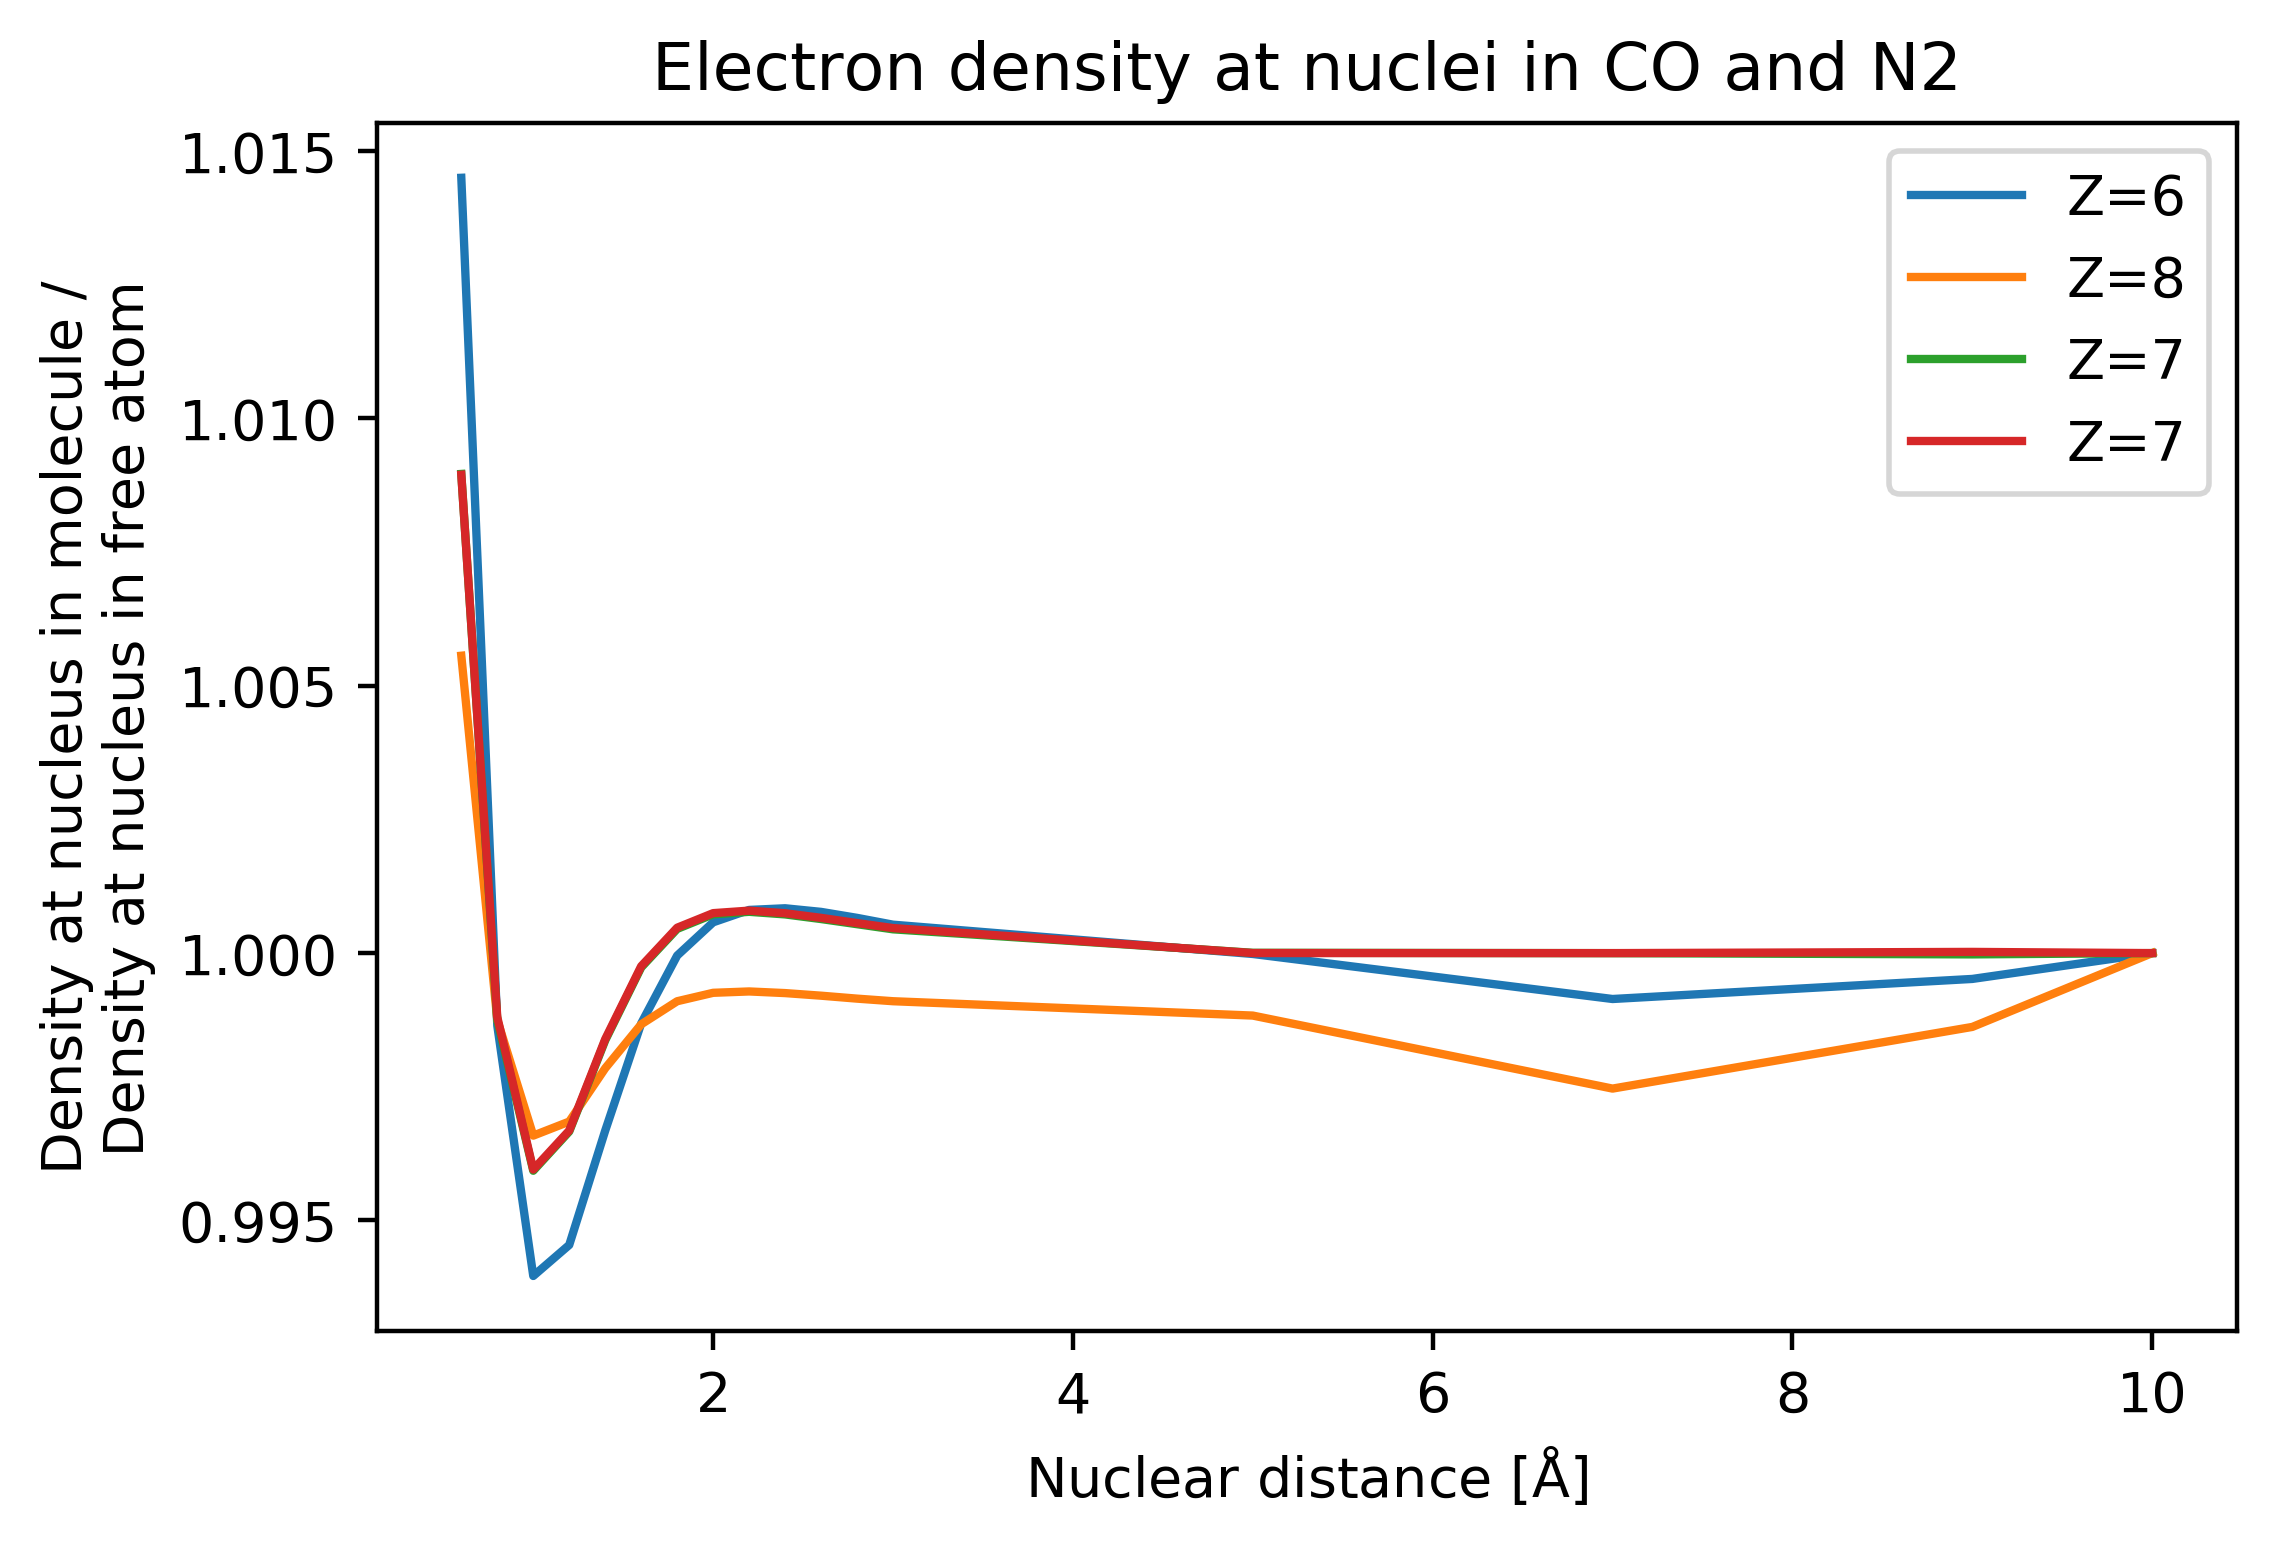

In [47]:
f = plt.figure(dpi=400)
for name, group in df.groupby('molname'):
    plt.plot(group.distance, group.rho1.values / group.rho1.values[-1], label='Z=%d' % group.z1.unique()[0])
    plt.plot(group.distance, group.rho2.values / group.rho2.values[-1], label='Z=%d' % group.z2.unique()[0])
plt.ylabel('Density at nucleus in molecule /\n Density at nucleus in free atom')
plt.xlabel('Nuclear distance [$\mathrm{\AA}$]')
plt.xlabel('Nuclear distance [$\mathrm{\AA}$]')
plt.title('Electron density at nuclei in CO and N2')
plt.legend()

In [38]:
df

""
